In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({
    'savefig.dpi': 300, 
    "figure.dpi": 300,
    "font.family": "Arial",
    "font.size": 6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "lines.linewidth": 1.0,
})

cm = 1/2.54  # centimeters in inches

In [17]:
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

from scipy.ndimage import gaussian_filter
from matplotlib.patches import Ellipse, Rectangle

In [18]:
### load vlba cleaned image
hdul = fits.open("../data/example.vlba.J1832-0911.clean.ii.fits")
data = np.squeeze(hdul[0].data)
header = hdul[0].header
wcs = WCS(header).celestial

dra = header["CDELT1"]
dde = header["CDELT2"]

radius = 128

data = data[256-radius//2:256+radius//2, 256-radius//2:256+radius//2]
ralen, delen = data.shape

rms = 0.00018

### for plotting contour
xx = (np.arange(0, ralen) - ralen//2) * dra * 3.6e6
yy = (np.arange(0, delen) - delen//2) * dde * 3.6e6

XX,YY = np.meshgrid(xx, yy)

Load `pmpar` fit result

In [19]:
tin = open("./pmpar_t")
tlines = tin.readlines()
tin.close()
ein = open("./pmpar_e")
elines = ein.readlines()
ein.close()
ttimes = []
tras =   []
tdecs =  []
etimes = []
eras =   []
edecs =  []
eraerr = []
edecerr= []
pras =   []
pdecs =  []
for line in tlines:
    splitline = line.split()
    ttimes.append(float(splitline[0]))
    tras.append(float(splitline[1]))
    tdecs.append(float(splitline[2]))
for line in elines:
    splitline = line.split()
    etimes.append(float(splitline[0]))
    eras.append(float(splitline[1]))
    edecs.append(float(splitline[3]))
    eraerr.append(float(splitline[2]))
    edecerr.append(float(splitline[4]))
    pras.append(float(splitline[5]))
    pdecs.append(float(splitline[6]))

Make VLBA plots

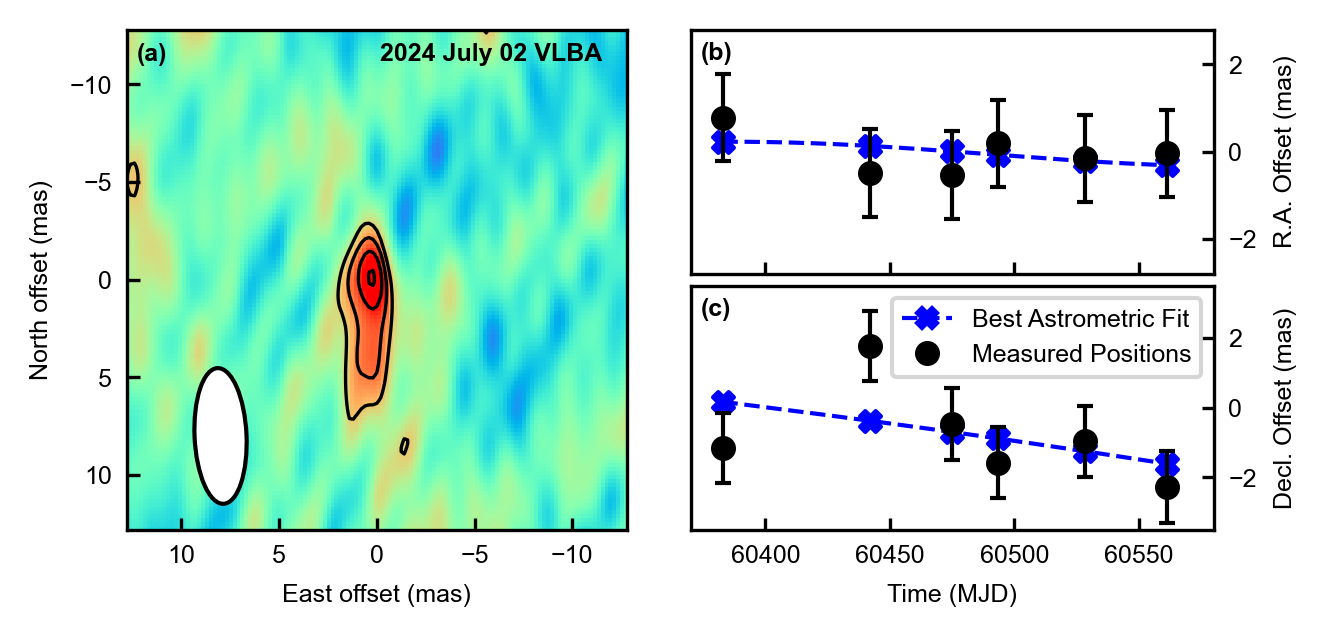

In [21]:
fig = plt.figure(figsize=(12*cm, 5.5*cm))
gs = gridspec.GridSpec(figure=fig, nrows=2, ncols=2, wspace=0.1, hspace=0.05)

ax = fig.add_subplot(gs[:, :1])
ax.imshow(
    data, #origin="lower", 
    extent=[
        -ralen/2*dra * 3.6e6, ralen/2*dra * 3.6e6, 
        -delen/2*dra * 3.6e6, delen/2*dra * 3.6e6, 
    ],
    cmap="rainbow", vmax=0.00115, vmin=-0.0009,
    interpolation="none"
)

ax.contour(XX, YY, data, levels=rms*np.array([3, 4.5, 6, 7.5]), colors="k", linewidths=0.8)
ax.set_xlabel("East offset (mas)")
ax.set_ylabel("North offset (mas)")

ell = Ellipse(
    (8, 8), abs(2*header["BMAJ"] * 3.6e6), abs(2*header["BMIN"] * 3.6e6),
    angle=90+header["BPA"], edgecolor="k", facecolor="white",
)

ax.add_patch(ell)

ax.text(
    0.95, 0.975, "2024 July 02 VLBA", va="top", ha="right", 
    transform=ax.transAxes, weight="bold", #bbox=dict(facecolor="white", edgecolor="none")
)

ax.text(
    0.02, 0.975, s="(a)", ha="left", va="top",  weight="bold",
    transform=ax.transAxes, color="k", #bbox=dict(facecolor="white", edgecolor="none")
)

######## plot pmpar fit ############
ax = fig.add_subplot(gs[0, 1])

ax.plot(ttimes, tras, color="blue", ls="--")
ax.scatter(etimes, pras, color="blue", s=25, marker="X")
ax.errorbar(etimes, eras, yerr=eraerr, marker="o", ls="none", color="k", capsize=2, markersize=5)
ax.set_ylim(-2.8, 2.8)
ax.set_xlim(60370, 60580)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel("R.A. Offset (mas)")
ax.set_xticklabels([])
ax.text(
    0.02, 0.95, s="(b)", ha="left", va="top",  weight="bold",
    transform=ax.transAxes, color="k", #bbox=dict(facecolor="white", edgecolor="none")
)



ax = fig.add_subplot(gs[1, 1])

ax.plot(ttimes, tdecs, color="blue", ls="--")
ax.scatter(etimes, pdecs, color="blue", s=25, marker="X")
ax.errorbar(etimes, edecs, yerr=edecerr, marker="o", ls="none", color="k", capsize=2, markersize=5)
### add label
ax.errorbar([], [], marker="o", ls="none", color="k", capsize=2, label="Measured Positions", markersize=5)
ax.plot([], [], color="blue", ls="--", marker="X", markersize=5, label="Best Astrometric Fit")

ax.set_ylim(-3.5, 3.5)
ax.set_xlim(60370, 60580)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel("Decl. Offset (mas)")
ax.set_xlabel("Time (MJD)")
ax.text(
    0.02, 0.95, s="(c)", ha="left", va="top",  weight="bold",
    transform=ax.transAxes, color="k", #bbox=dict(facecolor="white", edgecolor="none")
)

ax.legend()

fig.savefig("vlba_image_astrometry_fit.pdf", bbox_inches="tight", dpi=300)